In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_function import plot_loss_curves, pred_and_plot, view_random_image

In [4]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = os.path.join(target_dir,target_class)

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(os.path.join(target_folder,random_image[0]))
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img


def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);


def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Data

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-04-18 16:36:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   119MB/s    in 4.1s    

2022-04-18 16:36:42 (120 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [6]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [7]:
train_dir = os.path.join('10_food_classes_all_data', 'train')
test_dir = os.path.join('10_food_classes_all_data', 'test')

In [8]:
data_dir = os.listdir(train_dir)
class_names = sorted(data_dir)
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Image shape: (384, 512, 3)


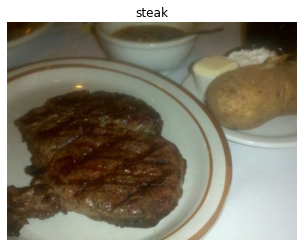

In [9]:
img = view_random_image(target_dir = '10_food_classes_all_data/train/',
                        target_class = "steak")

In [10]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               seed=42,
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               seed=42,
                                               batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Model 

In [16]:
def feature_extractor(inputs):
  '''
  Feature Extraction is performed by InceptionV3 pretrained on imagenet weights. 
  Input size is 224 x 224.
  '''

  feature_extractor = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


def classifier(inputs):
    '''
    Defines final dense layers and subsequent softmax layer for classification.
    '''
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model():
    '''
    Connect the feature extraction and "classifier" layers and builds the model.
    '''
    # Connects the layers
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    inception_net_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(inception_net_feature_extractor)

    # Builds the model
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    return model



In [17]:
# Create and compile the model
model = final_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

# Freeze pre-trained weights
model.layers[1].trainable = False

model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               26240

# Training

In [18]:
history = model.fit(train_data,
                      epochs=10,
                      validation_data=test_data
                      )

Epoch 1/10
235/235 [==============================] - 209s 833ms/step - loss: 1.4405 - accuracy: 0.5471 - val_loss: 2.7913 - val_accuracy: 0.3104
Epoch 2/10
235/235 [==============================] - 188s 800ms/step - loss: 1.0003 - accuracy: 0.6936 - val_loss: 2.2608 - val_accuracy: 0.4964
Epoch 3/10
235/235 [==============================] - 189s 803ms/step - loss: 0.8274 - accuracy: 0.7444 - val_loss: 1.5997 - val_accuracy: 0.5764
Epoch 4/10
235/235 [==============================] - 189s 804ms/step - loss: 0.7265 - accuracy: 0.7761 - val_loss: 1.4118 - val_accuracy: 0.5532
Epoch 5/10
235/235 [==============================] - 190s 806ms/step - loss: 0.6478 - accuracy: 0.7965 - val_loss: 0.8465 - val_accuracy: 0.7436
Epoch 6/10
235/235 [==============================] - 189s 804ms/step - loss: 0.5779 - accuracy: 0.8197 - val_loss: 1.6001 - val_accuracy: 0.5836
Epoch 7/10
235/235 [==============================] - 190s 805ms/step - loss: 0.5161 - accuracy: 0.8416 - val_loss: 1.0922 -

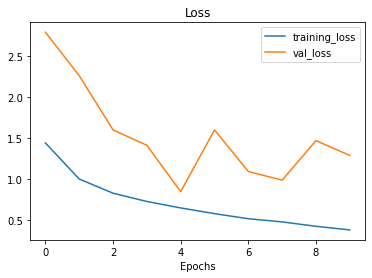

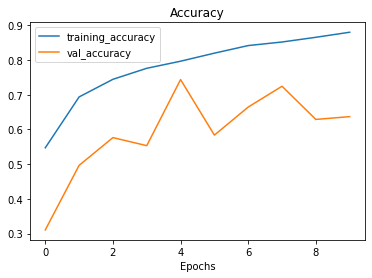

In [19]:
plot_loss_curves(history)

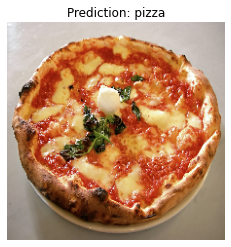

In [21]:
pred_and_plot(model, 'pizza.jpg', class_names)

## Fine Tuning

In [22]:
model.layers[1].trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), 
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                           

In [23]:
history = model.fit(train_data,
                      epochs=10,
                      validation_data=test_data
                      )

Epoch 1/10
235/235 [==============================] - 198s 807ms/step - loss: 0.2014 - accuracy: 0.9368 - val_loss: 0.5297 - val_accuracy: 0.8480
Epoch 2/10
235/235 [==============================] - 188s 800ms/step - loss: 0.1247 - accuracy: 0.9603 - val_loss: 0.4866 - val_accuracy: 0.8644
Epoch 3/10
235/235 [==============================] - 189s 801ms/step - loss: 0.0980 - accuracy: 0.9669 - val_loss: 0.6784 - val_accuracy: 0.8420
Epoch 4/10
235/235 [==============================] - 188s 798ms/step - loss: 0.1006 - accuracy: 0.9677 - val_loss: 0.6855 - val_accuracy: 0.8372
Epoch 5/10
235/235 [==============================] - 188s 800ms/step - loss: 0.0892 - accuracy: 0.9711 - val_loss: 0.7136 - val_accuracy: 0.8416
Epoch 6/10
235/235 [==============================] - 188s 799ms/step - loss: 0.0788 - accuracy: 0.9767 - val_loss: 0.5248 - val_accuracy: 0.8772
Epoch 7/10
235/235 [==============================] - 188s 800ms/step - loss: 0.0527 - accuracy: 0.9829 - val_loss: 0.7059 -

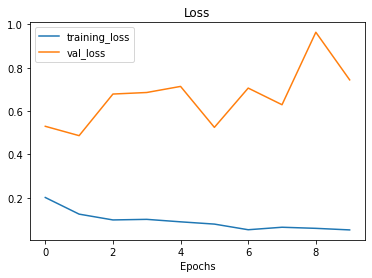

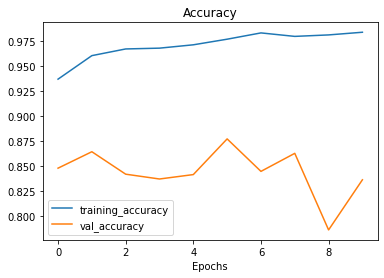

In [24]:
plot_loss_curves(history)

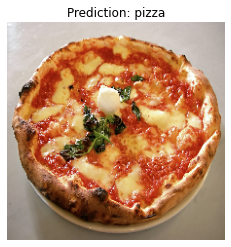

In [25]:
pred_and_plot(model, 'pizza.jpg', class_names)

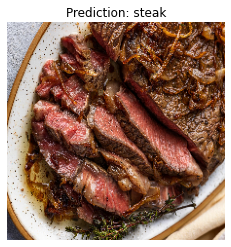

In [26]:
pred_and_plot(model, 'steak.jpg', class_names)